In [1]:
import numpy as np
import pandas as pd
import lxml
import matplotlib.pyplot as plt
from scipy import optimize as op
from cvxopt import solvers
from cvxopt import matrix

## Lets get the stock market data over last year from yahoo

In [51]:
import pandas as pd

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

df = first_table
df.head()
my_stocks = df['Symbol'].values.tolist()
n = len(my_stocks)
my_stocks.remove('BRK.B')
my_stocks.remove('BF.B')
my_stocks.remove('CARR')
my_stocks.remove('LUMN')
my_stocks.remove('OTIS')
my_stocks.remove('VNT')
# my_stocks = ['AAPL','BA','FB','GILD','REGI','SBUX','TWTR','DIS','GE','HD','DAL','GOOG','ABBV','JNJ','NEE','TSLA','SPY','GLD','F','AMGN','NKE']

In [52]:
import urllib.request

print('Downloading data...')

for symbol in my_stocks:
    url = 'https://query1.finance.yahoo.com/v7/finance/download/'+symbol+'?period1=1583884800&period2=1609113600&interval=1d&events=history&includeAdjustedClose=true'
    urllib.request.urlretrieve(url,'../data/'+symbol+'.csv')

## Now read the data using pandas

In [53]:
my_dict = {}
for symbol in my_stocks:
    my_dict[symbol] = pd.read_csv('../data/'+symbol+'.csv')

n = len(my_dict)
T = my_dict[symbol].shape[0]

my_dict['TWTR'].tail()

,Date,Open,High,Low,Close,Adj Close,Volume
197,2020-12-18,54.93,56.080002,54.270000,55.869999,55.869999,20450300
198,2020-12-21,54.50,55.680000,53.580002,54.639999,54.639999,10349400
199,2020-12-22,55.00,55.680000,54.369999,54.910000,54.910000,9259200
200,2020-12-23,55.34,55.450001,54.230000,54.299999,54.299999,6008600
201,2020-12-24,54.52,55.189999,53.860001,53.970001,53.970001,3661100


In [55]:
stocks = np.zeros([n,T])
for i, symbol in enumerate(my_stocks):
    try:
        stocks[i,:] = np.float32(my_dict[symbol].Close)
    except:
        print("some problem for data of",symbol)

times =  my_dict[symbol].Date

## Online newton step algorithm and expert

In [56]:
x = np.ones(n)/n
f = np.zeros(T)

# Parameter Free Expert
sum_g_tild = np.zeros(n)
sum_g_w = np.zeros(n)
x_0 = np.ones(n)/n
for t in range(T-1):

    w = sum_g_tild /(t+T/2)*(1+sum_g_w)
    x = x_0 * np.maximum(w, 0)

    if np.sum(x) > 0:
        x = x / np.sum(x)
    else:
        x = x_0

    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = r/np.dot(x, r)

    g_tild = grad - np.dot(grad, x)
    g_tild[w<0] = np.maximum(g_tild[w<0], 0)

    sum_g_tild += g_tild
    sum_g_w += g_tild

log_wealth_expert = np.cumsum(-f)

x_pfe = x
biggest = np.argsort(x)
print('PFE portfolio')
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_pfe[i]*100))+ '%')

PFE portfolio
TSLA	3.318%
ETSY	1.982%
FCX	1.463%
MGM	1.396%
LB	1.362%
HAL	1.324%
NCLH	1.256%
GPS	1.185%
APA	1.054%
DRI	1.029%
APTV	0.984%
ALGN	0.9766%
RCL	0.906%
URI	0.878%
PVH	0.819%
MOS	0.814%
FANG	0.796%
DFS	0.7905%
CCL	0.7437%
SIVB	0.698%
VTR	0.6895%
VIAC	0.6743%
LNC	0.668%
FDX	0.66%
DVN	0.6577%
ALB	0.6484%
CMG	0.64%
WYNN	0.629%
TPR	0.6245%
HWM	0.62%
EXPE	0.5967%
DXC	0.5923%
PYPL	0.5913%
SEE	0.5894%
IVZ	0.5854%
CTLT	0.5737%
WHR	0.556%
UAL	0.5283%
PWR	0.526%
LEN	0.525%
NVDA	0.5234%
TDG	0.5127%
PH	0.512%
EMN	0.5107%
OKE	0.509%
TWTR	0.5005%
GM	0.4963%
AVGO	0.4856%
PAYC	0.484%
HOLX	0.48%
SYF	0.4795%
CDNS	0.4727%
OXY	0.4707%
AMD	0.4678%
TER	0.4668%
LYB	0.4653%
LRCX	0.4624%
UAA	0.461%
IDXX	0.459%
DHI	0.4463%
HCA	0.4402%
AES	0.4333%
MCHP	0.431%
UA	0.4292%
ABMD	0.421%
MPC	0.4136%
LYV	0.408%
FBHS	0.408%
DOW	0.402%
IPGP	0.4006%
LKQ	0.3967%
QCOM	0.3965%
DAL	0.3857%
FITB	0.3833%
CFG	0.383%
DE	0.382%
MHK	0.3767%
CMA	0.3718%
UPS	0.3716%
PHM	0.3699%
ZBRA	0.3684%
QRVO	0.368%
ADSK	0.3677%
XLNX	0.36

In [57]:
def project(y, A):
    n = y.size

    P = matrix(A, tc='d')
    q = matrix(-2*np.matmul(y, A), tc='d')
    G = matrix(-np.eye(n), tc='d')
    h = matrix(np.zeros(n), tc='d')
    A = matrix(np.ones([1,n]), tc='d')
    b = matrix([1], tc='d')

    solvers.options['show_progress'] = False
    sol = solvers.qp(P,q,G,h,A,b)
    return np.array(sol['x']).reshape(-1)

In [60]:
# ONS
alpha = 0.6
G = np.sqrt(n)/alpha
gamma = 1/8/G
epsilon = 1/gamma**2
# gamma = 1
# epsilon = 1/8

# Initialization
A = epsilon*np.eye(n)
x = np.ones(n)/n
f = np.zeros(T)

# Algorithms
for t in range(T-1):
    r = stocks[:,t+1]/stocks[:,t]
    f[t] = - np.log(np.dot(x,r))
    grad = - r/np.dot(x, r)

    # ONS
    A = A + np.outer(grad, grad)
    y = x - 1/gamma * np.linalg.solve(A, grad)
    x = project(y, A)

log_wealth_ons = np.cumsum(-f)

x_ons = x

print('ONS portfolio')
biggest = np.argsort(x)
for i in biggest[::-1]:
    symbol=my_stocks[i]
    print(symbol + '\t'+str(np.float16(x_ons[i]*100))+ '%')

ONS portfolio
OXY	100.0%
FIS	6e-08%
LEN	6e-08%
PHM	6e-08%
MA	6e-08%
LRCX	6e-08%
WHR	6e-08%
KLAC	6e-08%
TFX	6e-08%
GPN	6e-08%
EQR	6e-08%
WELL	6e-08%
NVR	6e-08%
TSLA	6e-08%
BR	6e-08%
FISV	6e-08%
V	6e-08%
DHI	6e-08%
AMAT	6e-08%
MAA	6e-08%
FBHS	6e-08%
DG	6e-08%
TSCO	6e-08%
XLNX	6e-08%
ANTM	6e-08%
FRC	6e-08%
A	6e-08%
LMT	6e-08%
MDT	6e-08%
PH	6e-08%
VAR	6e-08%
RF	6e-08%
CF	6e-08%
MKTX	6e-08%
WRK	6e-08%
LYV	6e-08%
MAR	6e-08%
DXC	6e-08%
LKQ	6e-08%
HPE	6e-08%
DOW	6e-08%
AIZ	6e-08%
BK	6e-08%
CTSH	6e-08%
JCI	6e-08%
APTV	6e-08%
TAP	6e-08%
DIS	6e-08%
TMO	6e-08%
DVA	6e-08%
WRB	6e-08%
GRMN	6e-08%
LYB	6e-08%
NVDA	6e-08%
EXPD	6e-08%
AMGN	6e-08%
ROP	6e-08%
VIAC	6e-08%
STZ	6e-08%
TIF	6e-08%
IPG	6e-08%
ACN	6e-08%
ABBV	6e-08%
NWL	6e-08%
TEL	6e-08%
OMC	6e-08%
SBUX	6e-08%
BIO	6e-08%
ZBH	6e-08%
ALLE	6e-08%
UNM	6e-08%
IRM	6e-08%
EMR	6e-08%
NFLX	6e-08%
ADM	6e-08%
HPQ	6e-08%
WDC	6e-08%
HUM	6e-08%
GPC	6e-08%
WMB	6e-08%
CAG	6e-08%
GL	6e-08%
OKE	6e-08%
SLG	6e-08%
DFS	6e-08%
NKE	6e-08%
WMT	6e-08%
TGT	6e-08%
D	6e-08%

## Backtest results

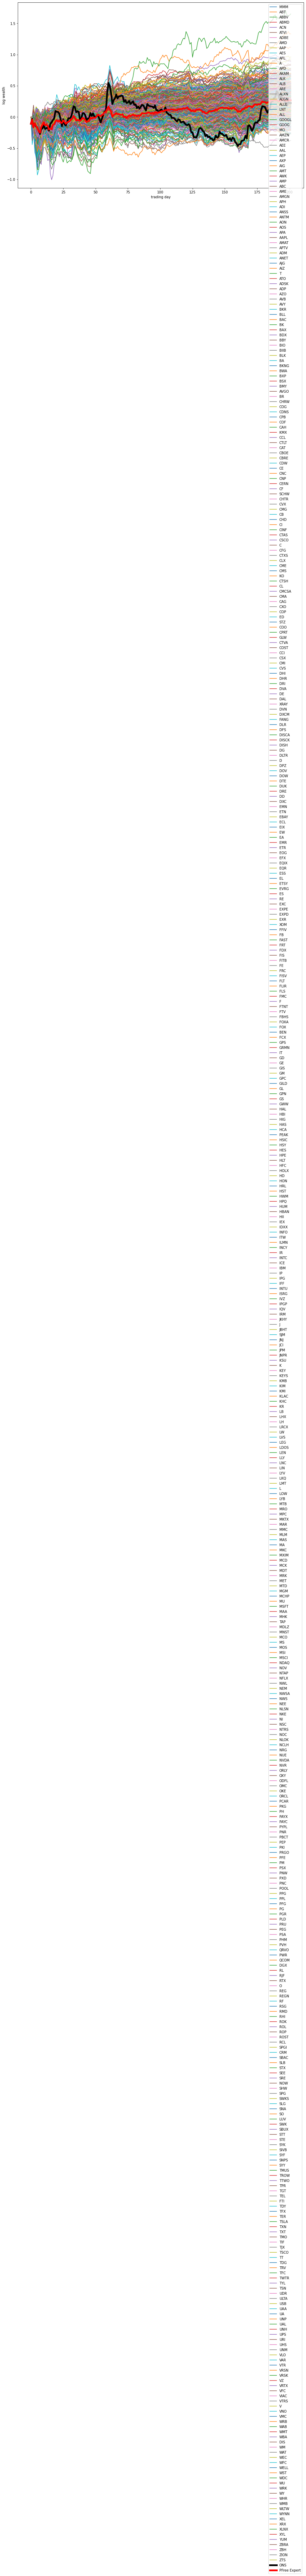

In [61]:
# Visualization
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

for i, symbol in enumerate(my_stocks):
    ax.plot(np.arange(T),np.log(stocks[i]) - np.log(stocks[i,0]), label=symbol)
for i, symbol in enumerate(my_stocks):
    ax.plot(np.arange(T),np.log(stocks[i]) - np.log(stocks[i,0]), label='AAPL')

ax.plot(np.arange(T), log_wealth_ons, 'k' , linewidth=5, label='ONS')
ax.plot(np.arange(T), log_wealth_expert, 'r' , linewidth=5, label='PFree Expert')

ax.legend()
ax.set_xlabel('trading day')
ax.set_ylabel('log wealth')
plt.show()